# Calibration of the 4 models using CALL OPTIONS
This notebook aims to find the optimal parameters of **Black-Scholes**, **Merton Jump Diffusion**, **Kou Jump Diffusion** and **Variance Gamma** models. To do so, we compute the european option prices using **closed formulas**, available for all the 4 models, and the **Fast Fourier Transform** for the VG model. Given these theoretical prices, the **implied volatilities** are computed comparing them with real market prices, minimizing their difference. Then we estimate the additional parameters of each model, using the python module `scipy.optimize`.

*reference: https://github.com/cantaro86/Financial-Models-Numerical-Methods/tree/master*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy.optimize as scpo
import sys
sys.path.append('C:/Users\ornel\PycharmProjects\Margin-Loans-Pricing/functions')
sys.path.append('C:/Users/ornel/PycharmProjects/Margin-Loans-Pricing/calibration')
import time

from MERTONpricer import Merton_pricer
from BSpricer import BS_Pricer
from KOUpricer import Kou_pricer
from VGpricer import VG_pricer

random.seed(120)

Let's start retrieving historical prices for **european call** options starting from date **2016-01-20** and expiring **1 year** later. All the data have been collected from [OptionsDX](https://www.optionsdx.com/shop/) and preprocessed in `plainvanilla.py` module. Only options such that the moneyness
$$ K/S0 \in [0.75, 1.35] $$ have been selected.

In [3]:
df_call = pd.read_csv('../../data/TSLA/OPT16_TSLA_CALLS_75_135.csv')
print(f'NUM OF CALL OPTS: {df_call.shape[0]}')
print(df_call)
df_call.to_csv('../../data/TSLA/TSLA_calls.csv', index=False)

NUM OF CALL OPTS: 17
    QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE  C_BID  C_ASK  STRIKE     C_IV  \
0   2016-01-20            198.7  2017-01-20  58.64  60.81   150.0  0.52003   
1   2016-01-20            198.7  2017-01-20  55.15  57.59   155.0  0.51390   
2   2016-01-20            198.7  2017-01-20  52.39  54.25   160.0  0.51061   
3   2016-01-20            198.7  2017-01-20  49.51  51.86   165.0  0.51231   
4   2016-01-20            198.7  2017-01-20  46.79  48.40   170.0  0.50543   
5   2016-01-20            198.7  2017-01-20  43.90  45.76   175.0  0.50075   
6   2016-01-20            198.7  2017-01-20  41.41  42.94   180.0  0.49715   
7   2016-01-20            198.7  2017-01-20  38.80  40.54   185.0  0.49343   
8   2016-01-20            198.7  2017-01-20  36.60  38.20   190.0  0.49195   
9   2016-01-20            198.7  2017-01-20  34.09  35.81   195.0  0.48620   
10  2016-01-20            198.7  2017-01-20  31.90  33.65   200.0  0.48345   
11  2016-01-20            198.7  2017-01-20

The dataframes **df_calls** contains 17 options sorted by their strike price. For our purpose, using them all can lead to very good results. Thus, we only reformulate the dataframe adding **Midpoint** and **Spread** columns.

In [4]:
calls = df_call.sample(frac=1, replace=False).sort_index().reset_index(drop=True)
calls['C_Midpoint'] = abs(calls['C_BID'] + calls['C_ASK']) / 2
calls['C_Spread'] = calls['C_BID'] - calls['C_ASK']

q = 0           # dividend yield
r = 0.03        # risk-free interest rate
sigma = 0.3     #volatility (variance of diffusion process)
S0 = calls.iloc[0]['UNDERLYING_LAST']
T = 1           # time-to-maturity
call_strikes = calls['STRIKE']    # array of K for call options
exercise = 'european'

call_prices = calls['C_Midpoint']

The following code snippet initializes objects of class *BS_pricer*, *Merton_pricer*, *Kou_pricer*, *VG_pricer* with default values as parameters. These parameters serve only as initialization. Best fitting parameetrs will be calibrated consequently and used to correctly price the options according to each model.

In [5]:
BS = BS_Pricer(S0=S0, r=r, q = q, sigma=sigma, ttm=T, exercise=exercise, K=None)
Merton = Merton_pricer(S0=S0, K=None, ttm=T, r=r, q = q, sigma=0.15, lambd=0.5, meanJ=-0.1, stdJ=0.1, exercise=exercise)
Kou = Kou_pricer(S0=S0, K=None, ttm=T, r=r, sigma=0.15, lambd=0.5, p=0.6, eta1=12, eta2=5, exercise=exercise)
VG = VG_pricer(S0, K=None, ttm=T, r=r, q=q, sigma=0.15, theta=-0.2, nu=0.3, exercise=exercise)

## Implied volatility
The function belows implements a methods to compute implied volatility: the [Bisection](https://en.wikipedia.org/wiki/Bisection_method) method. Apart from the initial guess, there is no substantial difference in the final result between **Newton** and **bisection** methods (*fsolve*). The **Implied Volatility** is that value $\sigma$ that must be inserted into the Black-Scholes (BS) formula in order to retrieve the option price quoted in the market:
    $$ BS(S, K, T, r, \sigma) = P,  $$
where $S$ is the underlying spot price, $K$ is the strike, $T$ time to maturity, $r$ risk-free interest rate and $P$ the option price quoted in the market. All these quantities are **observable**.
   

In [6]:
def implied_volatility(price, S, strike, t, rate, q, type_o, method='fsolve', disp=True ):
    """ Returns Implied volatility
        methods:  fsolve (default) or brent
    """

    def obj_fun(vol):
        return BS.BlackScholes(type_o=type_o, S0=S, K=strike, ttm=t, r=rate, q=q, sigma=vol) - price

    def vega(vol):
        return BS.vega(S, strike, rate, q, vol, t)

    if method =='fsolve':
        X0 = [0.01, 0.2, 0.35, 7]        #initial guess points for imp.vol.
        for x_0 in X0:
            x, _, solved, _ = scpo.fsolve(obj_fun, x_0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    if disp:
        return -1

The following code snippet computes the implied volatility of **call** options market prices and show a plot of the implied volatilities found by inversion method against the ones provided by the dataframe.

Implied volatilities of market prices (calls):
S0 = 198.7
K = 210.0, IV = 0.4742
K = 220.0, IV = 0.4686
K = 230.0, IV = 0.4733
K = 240.0, IV = 0.4577
K = 250.0, IV = 0.4502
K = 260.0, IV = 0.447


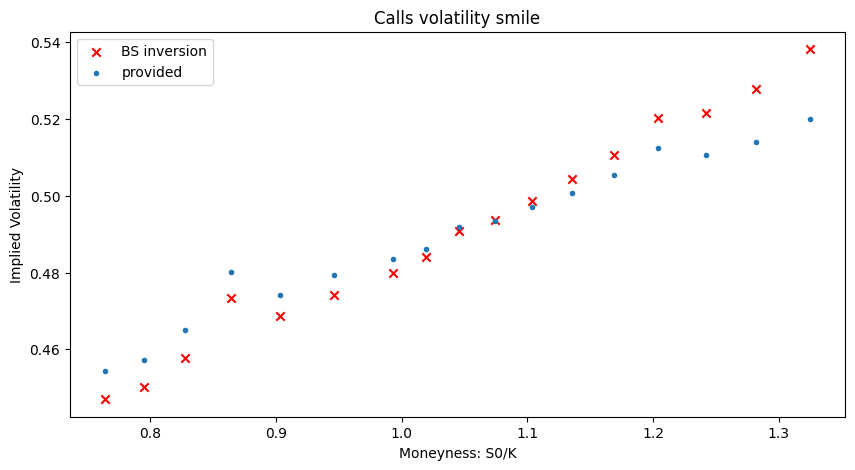

In [7]:
IV_market = []
for i in range(len(call_prices)):
    IV_market.append(implied_volatility(call_prices[i], S=S0, strike=call_strikes[i], t = T, rate=0.03, q = 0.06, type_o='call', method='fsolve'))

print(f'Implied volatilities of market prices (calls):\nS0 = {S0}')
for a,b in zip(call_strikes.tail(6), IV_market[-6:]):
    print(f'K = {a}, IV = {round(b, 4)}')

# Plot market implied volatilities w.r.t. log moneyness
x = (S0/call_strikes)
IV_filtered = [iv for iv in IV_market if iv != -1]
x_filtered = [log_m for iv, log_m in zip(IV_market, x) if iv != -1]

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.scatter(x, IV_market, marker='x', label='BS inversion', color='red')
ax1.scatter(x, calls['C_IV'], marker='.', label='provided')
ax1.set_xlabel('Moneyness: S0/K'); ax1.set_ylabel('Implied Volatility'); ax1.set_title('Calls volatility smile')
ax1.legend(); plt.show()


##  Weighted Calibration (call options)
Let's step now into the calibration of model parameters.
If we define $\Theta$ the set of parameters, the goal is to find the optimal parameters $\Theta^*$ that minimize the following objective function:
$$ \sum_{i=1}^{N} w_i \biggl( P_i - f(K_i|\Theta) \biggr)^2 $$
where $w_i$ are weights, usually defined as
$$ w_i = \frac{1}{\text {spread}_i^2 },$$ $P_i$ are the market prices and $f$ is the pricing function. In our case $f$ is given by **Merton** Jump Diffusion model, **Kou** Jump Diffusion model, or **Variance Gamma** process. To perform this optimization problem, many numerical methods can be used. In particular, we test two functions of `scipy.optimize`:
1. **curve_fit**, a least-squares curve fitting method which works with bounds. The default algorithm is [Trust Region Reflective (trf)](https://en.wikipedia.org/wiki/Trust_region). The [Levemberg-Marquadt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) has been tried as well, to test the optimization problem without setting boundaries, but the results don't make any sense.
2. **Least-Squares**, a constrained minimization problem which uses Trust region reflective method by default. This method is the most indicated to solve the non-linear least squares optimization problem of our purpose.
All the optimizations are carried out by initializing a starting point as the array $x_0 = [params]$ and setting feasible bounds.


In [8]:
call_spreads = calls['C_Spread']
c_weights = 1/ call_spreads**2

### Black and Scholes model
The only unknown parameter to calibrate in Black and Scholes model is the **implied volatility**, $\sigma$. Thus, we minimize the difference between the computed theoretical prices and the market prices of call options.

In [9]:
x0 = 0.5
bounds = [1e-5, 2]

def f_BlackScholes_calls(x, sigm):
    BS = BS_Pricer(S0=S0, K = x, ttm=T, r=r, q=0, sigma=sigm, exercise=exercise)
    return BS.closed_formula_call(x)

res1_calls = scpo.curve_fit(f_BlackScholes_calls, call_strikes, call_prices, p0 = x0, bounds=bounds, sigma=c_weights)
sigw_p = round(res1_calls[0][0],4)

In [10]:
def cost_function(x, strikes, mkt_prices):
    sigma = x
    BS = BS_Pricer(S0=S0, K = None, ttm=T, r=r, q=0, sigma=sigma, exercise=exercise)
    sq_err = np.sum(c_weights* (BS.closed_formula_call(strikes) - mkt_prices)**2)
    return sq_err

result_p = scpo.least_squares(cost_function, x0, args=(call_strikes, call_prices), bounds=bounds, method = 'trf', verbose=1)
calls_bs_params_tsla = result_p.x[0]

`ftol` termination condition is satisfied.
Function evaluations 21, initial cost 5.5531e+04, final cost 9.0955e-01, first-order optimality 3.94e-03.


In [11]:
print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatility from Calls [σ] = {sigw_p} \t {round(sigw_p*100,2)}%')
print('METHOD 2: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatility from Calls [σ] = {calls_bs_params_tsla} \t {round(calls_bs_params_tsla*100,2)}%')

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatility from Calls [σ] = 0.3902 	 39.02%
METHOD 2: LEAST-SQUARES (trf)
> Calibrated Volatility from Calls [σ] = 0.38916942193658266 	 38.92%


Save parameters to use in other notebooks

In [15]:
%store calls_bs_params_tsla

Stored 'calls_bs_params_tsla' (float64)


### Merton Jump Diffusion
The Merton Jump diffusion ones are the volatility $\sigma$, the Poisson rate of jumps $\lambda$, the mean rate of jump intensity $m$ and its variance rate $v$, assuming that the intensity of jumps follows a *Normal distribution*.


In [16]:
x0 = [0.15,  0.2, -0.05,  0.01]  # initial guess: [σ, λ, m, v]
bounds = ( [1e-3, 1e-2, -5, 1e-5], [2, 5, 5, 2] )

In [17]:
def f_Mert(x, sigma, lambd, meanJ, stdJ):
    Mert = Merton_pricer(S0=S0, K=x, ttm=T, r=r, q=0, sigma=sigma, lambd=lambd, meanJ=meanJ, stdJ=stdJ, exercise=exercise)
    return Mert.closed_formula_call(x)

start1=time.time()
mert1 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0, bounds=bounds, sigma=call_spreads)
end1=time.time()

mert_params1 = [round(p,4) for p in mert1[0][:4]]

##### Method 2. Least-squares

In [18]:
x0 = [0.15,  0.5, -0.05,  0.1]      # initial guess: [σ, λ, m, v]
bounds = ( [1e-3, 1e-2, -10, 0], [2, np.inf, 10, 5] )

def cost_function(x, strikes, mkt_prices):
    sigma, lambd, meanJ, stdJ = x
    M = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
    sq_err = np.sum(c_weights*(M.closed_formula_call(strikes) - mkt_prices)**2)
    return sq_err

start2 = time.time()
mert2 = scpo.least_squares(cost_function, x0, args=(call_strikes, call_prices), bounds=bounds, method = 'trf', verbose=1)
end2 = time.time()

The maximum number of function evaluations is exceeded.
Function evaluations 400, initial cost 6.2819e+05, final cost 3.0599e-01, first-order optimality 6.17e-01.


In [19]:
mert_params2 = [round(p,4) for p in mert2.x[:4]]

In [20]:
print('WEIGHTED OPT: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {round(mert1[0][0],4)} \t {round(mert1[0][0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert1[0][1],2))
print('> Calibrated Jump Mean = ', round(mert1[0][2],2))
print('> Calibrated Jump St. dev.  = ', round(mert1[0][3],5))
print(f'ELAPSED TIME: {end1-start1} sec')

print('\nMETHOD 1: LEAST SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {mert_params2[0]} \t {round(mert_params2[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert_params2[1],2))
print('> Calibrated Jump Mean = ', round(mert_params2[2],3))
print('> Calibrated Jump St. dev.  = ', round(mert_params2[3],3))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

WEIGHTED OPT: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.2326 	 23.26%
> Calibrated Jump intensity [λ] =  5.0
> Calibrated Jump Mean =  0.14
> Calibrated Jump St. dev.  =  1e-05
ELAPSED TIME: 32.38830876350403 sec

METHOD 1: LEAST SQUARES (trf)
> Calibrated Volatlity [σ] = 0.3062 	 30.62%
> Calibrated Jump intensity [λ] =  1.0
> Calibrated Jump Mean =  0.054
> Calibrated Jump St. dev.  =  0.232
TIME ELAPSED:  90.19 sec


In [21]:
print(mert_params1)
print(mert_params2)
calls_mert_params_tsla = mert_params2
%store calls_mert_params_tsla

[0.2326, 5.0, 0.1354, 0.0]
[0.3062, 0.9971, 0.0544, 0.2319]
Stored 'calls_mert_params_tsla' (list)


### Kou Jump Diffusion


In [31]:
x0 = [0.2, 0.7, 0.5, 8, 10] # initial guess: [σ, λ, p, η_1, η_2]
bounds = ( [1e-2, 1e-1, 0, 0.5, 0.5], [0.5, 4, 1, 15, 20] )

##### Method 1. TRF (Bounds)

In [32]:
# def f_Kou(x, sigma, lambd, p, eta1, eta2):
#     KouJD = Kou_pricer(S0=S0, K=x, ttm=T, r=r, sigma=sigma, lambd=lambd, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
#     return KouJD.closed_formula_call(x)
#
# start1 = time.time()
# kou1 = scpo.curve_fit(f_Kou, call_strikes, call_prices, p0=x0, bounds=bounds, sigma=c_weights)
# end1 = time.time()
#
# kou_params1 = [round(p,4) for p in kou1[0][:5]]

##### Method 2. LEAST SQUARES (With Bounds)

In [33]:
# Define the objective function
def cost_function(x, strikes, mkt_prices):
    sigm, lamb, p, eta1, eta2 = x
    KOU = Kou_pricer(S0=S0, K=strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    sq_err = np.sum(c_weights*(KOU.closed_formula_call(strikes) - mkt_prices)**2)
    return sq_err

start2=time.time()
kou2 = scpo.least_squares(cost_function, x0, args=(call_strikes, call_prices),  method='trf', bounds=bounds, verbose=2)
end2=time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5702e+05                                    1.01e+06    
       1              2         1.8878e+04      1.38e+05       8.46e-02       1.76e+05    
       2              3         2.0903e+03      1.68e+04       4.83e-02       2.89e+04    
       3              4         2.0464e+02      1.89e+03       2.92e-02       4.43e+03    
       4              5         1.8610e+01      1.86e+02       1.76e-02       6.33e+02    
       5              6         1.9481e+00      1.67e+01       1.08e-02       8.26e+01    
       6              7         5.6974e-01      1.38e+00       8.46e-03       4.76e+00    
       7             12         5.6785e-01      1.89e-03       2.70e-04       1.12e+00    
       8             13         5.6740e-01      4.48e-04       6.50e-04       1.24e+00    
       9             14         5.6723e-01      1.68e-04       1.19e-03       2.99e+00    

In [53]:
kou_params2 = [round(p,4) for p in kou2.x[:5]]

In [54]:
# print('WEIGHTED OPT: CURVE_FIT (trf)')
# print(f'> Calibrated Volatlity [σ] = {kou_params1[0]} \t {kou_params1[0] * 100}%')
# print('> Calibrated Jump intensity [λ] = ', kou_params1[1])
# print(f'> Calibrated Upward Jump probability [p] = {kou_params1[2]}, [q] = {round(1 - kou_params1[2], 2)}')
# print('> Calibrated Rate of Exp. 1  [η_1] = ', kou_params1[3])
# print('> Calibrated Rate of Exp. 2  [η_2] = ', kou_params1[4])
# print(f'TIME ELAPSED: {end1-start1} sec')

In [55]:
print('METHOD 2: Least-squares')
print(f'> Calibrated Volatlity [σ] = {round(kou_params2[0],4)} \t {round(kou_params2[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(kou_params2[1],2))
print(f'> Calibrated Upward Jump probability [p] = {round(kou_params2[2],2)}, [q] = {round(1-kou_params2[2],2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(kou_params2[3],2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(kou_params2[4],2))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

METHOD 2: Least-squares
> Calibrated Volatlity [σ] = 0.3547 	 35.47%
> Calibrated Jump intensity [λ] =  0.92
> Calibrated Upward Jump probability [p] = 0.57, [q] = 0.43
> Calibrated Rate of Exp. 1  [η_1] =  7.84
> Calibrated Rate of Exp. 2  [η_2] =  10.03
TIME ELAPSED:  403.77 sec


In [56]:
#print(kou_params1)
print(kou_params2)
calls_kou_params_tsla = kou_params2
%store calls_kou_params_tsla

[0.3547, 0.9235, 0.5685, 7.8424, 10.0337]


### Variance Gamma


In [42]:
x0 = [0.25, -0.2, 0.2]   # initial guess: [σ, θ, v]
bounds = ( [1e-3, -5, 0], [1, 5, 5] )

##### Method 1. CURVE FIT (Bounds)

In [ ]:
def f_VG(strikes, sigmax, thetax, nux):
    VGamma = VG_pricer(S0=S0, K=None, ttm=T, r=r, q=0, sigma=sigmax, theta=thetax, nu=nux, exercise=exercise)
    vg_prices = []
    for k in strikes:
        vg_prices.append(VGamma.closed_formula_call(k))
    return vg_prices

start1 = time.time()
vg1 = scpo.curve_fit(f_VG, call_strikes, call_prices, p0=x0, bounds=bounds, sigma=c_weights)
end1 = time.time()

In [57]:
vg_params1 = [round(p,4) for p in vg1[0][:3]]

##### Method 2. LEAST-SQUARES (Trust Region Reflective, Bounds)

In [ ]:
def cost_function(x, strikes, mkt_prices):
    sigma, theta, nu = x
    VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
    prices = []
    for k in strikes:
        prices.append(VG.closed_formula_call(k))
    sq_err = np.sum(c_weights*(prices - mkt_prices)**2)
    return sq_err

start2=time.time()
vg2 = scpo.least_squares(cost_function, x0, args=(call_strikes, call_prices),  method='trf', bounds=bounds, verbose=2, loss='soft_l1')
end2=time.time()

In [58]:
vg_params2 = [round(p,4) for p in vg2.x[:3]]

In [59]:
print('WEIGHTED OPT: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {vg_params1[0]}, \t {round(vg_params1[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params1[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params1[2])
print(f'TIME ELAPSED:  {round(end1-start1,2)} sec')

print('METHOD 1: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {vg_params2[0]}, \t {round(vg_params2[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params2[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params2[2])
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

WEIGHTED OPT: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.0304, 	 3.04%
> Calibrated mean rate gamma process [θ] =  -1.9524
> Calibrated variance rate gamma process [v]=  0.0374
TIME ELAPSED:  313.15 sec
METHOD 1: LEAST-SQUARES (trf)
> Calibrated Volatlity [σ] = 0.3917, 	 39.17%
> Calibrated mean rate gamma process [θ] =  -0.0513
> Calibrated variance rate gamma process [v]=  0.234
TIME ELAPSED:  403.77 sec


In [60]:
print(vg_params1)
print(vg_params2)
calls_vg_params_tsla = vg_params2
%store calls_vg_params_tsla

[0.0304, -1.9524, 0.0374]
[0.3917, -0.0513, 0.234]


### Reprice options using calibrated parameters
Once we have calibrated all the models, we test our parameters calibration by repricing the original dataframe of options. The table contains all the **BID**, **ASK** and **MIDPOINT** prices. The calibration is well perfromed if the prices we obtain belong to the interval $[BID, ASK]$.

In [61]:
days = 252
paths = 1000

call_calib_prices = pd.DataFrame({
    'STRIKE': calls['STRIKE'],    # array of K for call options
    'MKT_BID': calls['C_BID'],
    'MKT_MID': calls['C_Midpoint'],
    'MKT_ASK': calls['C_ASK'],

})
print(f'MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. \n\n{call_calib_prices}')

MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. 

    STRIKE  MKT_BID  MKT_MID  MKT_ASK
0    150.0    58.64   59.725    60.81
1    155.0    55.15   56.370    57.59
2    160.0    52.39   53.320    54.25
3    165.0    49.51   50.685    51.86
4    170.0    46.79   47.595    48.40
5    175.0    43.90   44.830    45.76
6    180.0    41.41   42.175    42.94
7    185.0    38.80   39.670    40.54
8    190.0    36.60   37.400    38.20
9    195.0    34.09   34.950    35.81
10   200.0    31.90   32.775    33.65
11   210.0    27.96   28.880    29.80
12   220.0    24.60   25.355    26.11
13   230.0    21.55   22.920    24.29
14   240.0    18.45   19.300    20.15
15   250.0    15.80   16.575    17.35
16   260.0    13.51   14.430    15.35


#### Merton Jump Diffusion model

In [62]:

sigma, lambd, meanJ, stdJ = mert_params2
MertonCAL = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
SMerton_CAL = MertonCAL.MertonPath(days, paths)

avg_payoffs = []
for k in call_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SMerton_CAL[-1]:
        payoffs.append(MertonCAL.payoff_call(k, St))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(call_calib_prices))
merton_cf_prices = np.zeros(len(call_calib_prices))

for index in range(len(call_calib_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    merton_cf_prices[index] = MertonCAL.closed_formula_call(call_strikes[index])

call_calib_prices['MERTON MC'] = merton_mc_prices
call_calib_prices['MERTON CF'] = merton_cf_prices

print(call_calib_prices)

    STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC  MERTON CF
0    150.0    58.64   59.725    60.81  61.184697  60.635060
1    155.0    55.15   56.370    57.59  57.708725  57.164951
2    160.0    52.39   53.320    54.25  54.370125  53.843501
3    165.0    49.51   50.685    51.86  51.193877  50.672172
4    170.0    46.79   47.595    48.40  48.200974  47.651215
5    175.0    43.90   44.830    45.76  45.380824  44.779775
6    180.0    41.41   42.175    42.94  42.696694  42.056003
7    185.0    38.80   39.670    40.54  40.146511  39.477180
8    190.0    36.60   37.400    38.20  37.717557  37.039842
9    195.0    34.09   34.950    35.81  35.408990  34.739907
10   200.0    31.90   32.775    33.65  33.208742  32.572788
11   210.0    27.96   28.880    29.80  29.128163  28.616829
12   220.0    24.60   25.355    26.11  25.497037  25.129307
13   230.0    21.55   22.920    24.29  22.343568  22.065713
14   240.0    18.45   19.300    20.15  19.528086  19.381809
15   250.0    15.80   16.575    17.35  1

In [63]:
sigma, lambd, p, eta1, eta2 = kou_params2
KouCAL = Kou_pricer(S0, None, T, r, sigma, lambd, p, eta1, eta2, exercise)
SKou_CAL = KouCAL.KouPath(days, paths)

avg_payoffs = []
for k in call_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SKou_CAL[-1]:
        payoffs.append(KouCAL.payoff_call(k, St))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(call_calib_prices))
kou_cf_prices = np.zeros(len(call_calib_prices))

for index in range(len(call_calib_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    kou_cf_prices[index] = KouCAL.closed_formula_call(call_strikes[index])

call_calib_prices['KOU MC'] = kou_mc_prices
call_calib_prices['KOU CF'] = kou_cf_prices

selection = [0,1,2,3,6,7]
print(call_calib_prices.iloc[:, selection])

    STRIKE  MKT_BID  MKT_MID  MKT_ASK     KOU MC     KOU CF
0    150.0    58.64   59.725    60.81  59.347331  60.850401
1    155.0    55.15   56.370    57.59  55.833165  57.387349
2    160.0    52.39   53.320    54.25  52.498066  54.067619
3    165.0    49.51   50.685    51.86  49.320301  50.892381
4    170.0    46.79   47.595    48.40  46.337800  47.861785
5    175.0    43.90   44.830    45.76  43.520275  44.975053
6    180.0    41.41   42.175    42.94  40.884766  42.230569
7    185.0    38.80   39.670    40.54  38.362936  39.625981
8    190.0    36.60   37.400    38.20  35.945061  37.158300
9    195.0    34.09   34.950    35.81  33.659669  34.823999
10   200.0    31.90   32.775    33.65  31.492487  32.619105
11   210.0    27.96   28.880    29.80  27.501580  28.579935
12   220.0    24.60   25.355    26.11  23.968845  25.003281
13   230.0    21.55   22.920    24.29  20.870864  21.849421
14   240.0    18.45   19.300    20.15  18.207187  19.078212
15   250.0    15.80   16.575    17.35  1

In [64]:

sigm, theta, nu = vg_params2
VGCAL = VG_pricer(S0, None, T, r, q, sigm, theta, nu, exercise)
SVarGamma_CAL = VGCAL.VarianceGammaPath2(days, paths)

avg_payoffs = []
for k in call_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SVarGamma_CAL[-1]:
        payoffs.append(VGCAL.payoff_call(k, St))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(call_calib_prices))
vg_cf_prices = np.zeros(len(call_calib_prices))

for index in range(len(call_calib_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    vg_cf_prices[index] = VGCAL.closed_formula_call(call_strikes[index])

call_calib_prices['VG MC'] = vg_mc_prices
call_calib_prices['VG CF'] = vg_cf_prices

selection = [0,1,2,3,8,9]
print(call_calib_prices.iloc[:, selection])

    STRIKE  MKT_BID  MKT_MID  MKT_ASK      VG MC      VG CF
0    150.0    58.64   59.725    60.81  62.429076  60.733460
1    155.0    55.15   56.370    57.59  58.795343  57.234286
2    160.0    52.39   53.320    54.25  55.292250  53.883682
3    165.0    49.51   50.685    51.86  51.949840  50.684556
4    170.0    46.79   47.595    48.40  48.746699  47.638438
5    175.0    43.90   44.830    45.76  45.673234  44.745511
6    180.0    41.41   42.175    42.94  42.707394  42.004676
7    185.0    38.80   39.670    40.54  39.841206  39.413666
8    190.0    36.60   37.400    38.20  37.144967  36.969187
9    195.0    34.09   34.950    35.81  34.621163  34.667072
10   200.0    31.90   32.775    33.65  32.227073  32.502452
11   210.0    27.96   28.880    29.80  27.818036  28.563686
12   220.0    24.60   25.355    26.11  23.975797  25.105826
13   230.0    21.55   22.920    24.29  20.631086  22.079626
14   240.0    18.45   19.300    20.15  17.755924  19.436596
15   250.0    15.80   16.575    17.35  1

In [65]:
print(call_calib_prices)

    STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC  MERTON CF     KOU MC   
0    150.0    58.64   59.725    60.81  61.184697  60.635060  59.347331  \
1    155.0    55.15   56.370    57.59  57.708725  57.164951  55.833165   
2    160.0    52.39   53.320    54.25  54.370125  53.843501  52.498066   
3    165.0    49.51   50.685    51.86  51.193877  50.672172  49.320301   
4    170.0    46.79   47.595    48.40  48.200974  47.651215  46.337800   
5    175.0    43.90   44.830    45.76  45.380824  44.779775  43.520275   
6    180.0    41.41   42.175    42.94  42.696694  42.056003  40.884766   
7    185.0    38.80   39.670    40.54  40.146511  39.477180  38.362936   
8    190.0    36.60   37.400    38.20  37.717557  37.039842  35.945061   
9    195.0    34.09   34.950    35.81  35.408990  34.739907  33.659669   
10   200.0    31.90   32.775    33.65  33.208742  32.572788  31.492487   
11   210.0    27.96   28.880    29.80  29.128163  28.616829  27.501580   
12   220.0    24.60   25.355    26.11 

### Visualize calibration results

#### Closed Formulas Option pricing

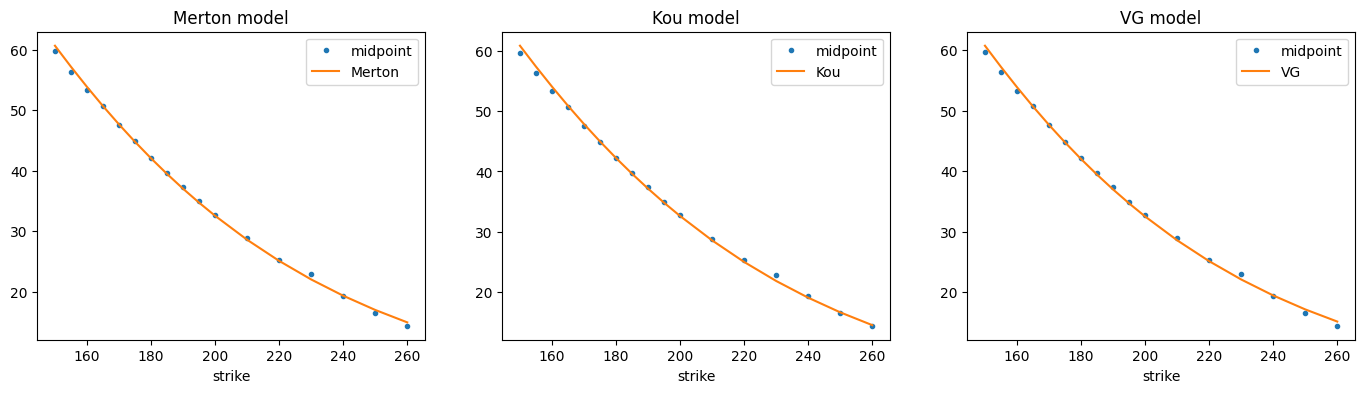

In [66]:
fig = plt.figure(figsize=(17, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(call_strikes, call_prices, ".", label="midpoint")
ax2.plot(call_strikes, call_prices, ".", label="midpoint")
ax3.plot(call_strikes, call_prices, ".", label="midpoint")
ax1.plot(call_strikes, merton_cf_prices, label="Merton")
ax2.plot(call_strikes, kou_cf_prices, label="Kou")
ax3.plot(call_strikes, vg_cf_prices, label="VG")
ax1.set_title("Merton model")
ax2.set_title("Kou model")
ax3.set_title("VG model")
ax1.set_xlabel("strike")
ax2.set_xlabel("strike")
ax3.set_xlabel("strike")
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

#### Monte Carlo option pricing

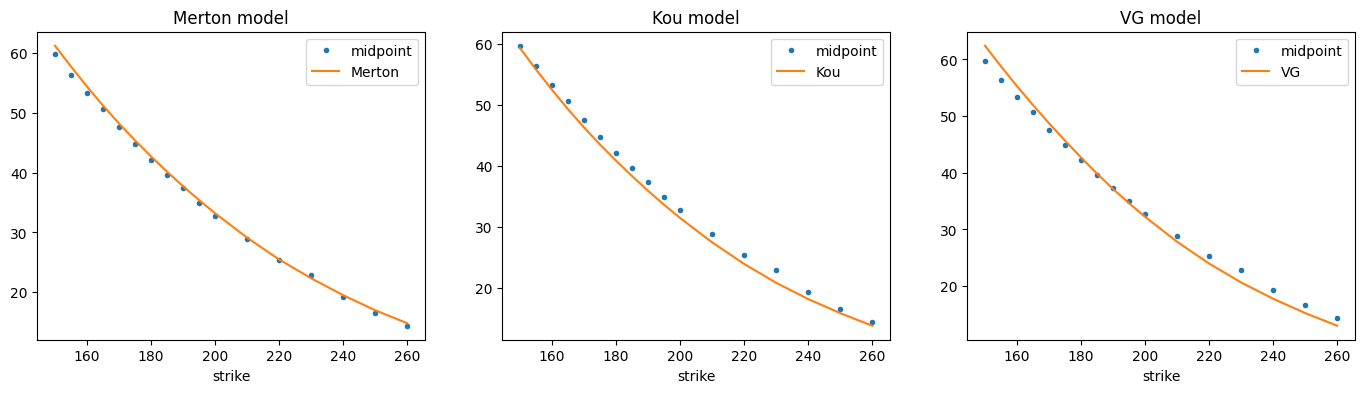

In [67]:
fig = plt.figure(figsize=(17, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(call_strikes, call_prices, ".", label="midpoint")
ax2.plot(call_strikes, call_prices, ".", label="midpoint")
ax3.plot(call_strikes, call_prices, ".", label="midpoint")
ax1.plot(call_strikes, merton_mc_prices, label="Merton")
ax2.plot(call_strikes, kou_mc_prices, label="Kou")
ax3.plot(call_strikes, vg_mc_prices, label="VG")
ax1.set_title("Merton model")
ax2.set_title("Kou model")
ax3.set_title("VG model")
ax1.set_xlabel("strike")
ax2.set_xlabel("strike")
ax3.set_xlabel("strike")
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()